<a href="https://colab.research.google.com/github/gandhimonil9823/CS_GO_Analysis/blob/main/GunPlay_Economics_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt_kwargs = {'figsize': (10, 4)}
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount(r'drive/folders/0AAxMXLC9WPNxUk9PVA')


Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [4]:
cd 'drive/Shared drives/CS_GO_Data/processed_data_v2'

/content/drive/Shared drives/CS_GO_Data/processed_data_v2


In [5]:
ls

aggregated_data/  de_nuke.png       mm_grenades_demos.csv
cs_cruise.png     de_overpass.png   out-de_cache.png
damage_data.csv   de_royal.png      out-de_cbble.png
de_cache.png      de_santorini.png  out-de_dust2.png
de_cbble.png      de_season.png     out-de_inferno.png
de_coast.png      de_train.png      out-de_mirage.png
de_dust2.png      de_tulip.png      out-de_overpass.png
de_empire.png     grenade_data.csv  out-de_train.png
de_inferno.png    kill_data.csv     winnerSide_matches.csv
de_mikla.png      Log_ROC.png       winnerSide_rounds.csv
de_mirage.png     map_data.csv      winnerSide_teams.csv
de_new_nuke.png   meta_data.csv


# GunPlay Economics Analysis


In [6]:
# Params : 1) data =  Dataframe single column or Array of multiple columns or the entire dataframe (to plot all columns)
#                     Eg : Single column - distribution_single_plot_kde(df_master_kills_demos["ct_eq_val"])
#                     Eg : Multiple columns - distribution_single_plot_kde([df_master_kills_demos["ct_eq_val"], df_master_kills_demos["t_eq_val"]])

#          2) title = String Input 
#                     Default : None (Wont add a title)

def distribution_plot_kde(data, title=None):
  sns.kdeplot(data= data)
  if title != None:
    plt.suptitle(title)



In [7]:
df_master_kills_demos = pd.read_csv("meta_data.csv")

df_master_kills_demos

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Team 2,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Team 2,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Team 2,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Team 2,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Team 1,CounterTerrorist,ECO,5400,20550
...,...,...,...,...,...,...,...,...,...,...
340328,esea_match_13829173.dem,de_mirage,18,1647.20600,1694.6550,Team 1,Terrorist,ECO,4500,21950
340329,esea_match_13829173.dem,de_mirage,19,1694.65500,1753.4380,Team 1,Terrorist,NORMAL,16400,26100
340330,esea_match_13829173.dem,de_mirage,20,1753.43800,1803.6580,Team 1,Terrorist,FORCE_BUY,15100,26000
340331,esea_match_13829173.dem,de_mirage,21,1803.65800,1856.0850,Team 1,Terrorist,NORMAL,17550,25500


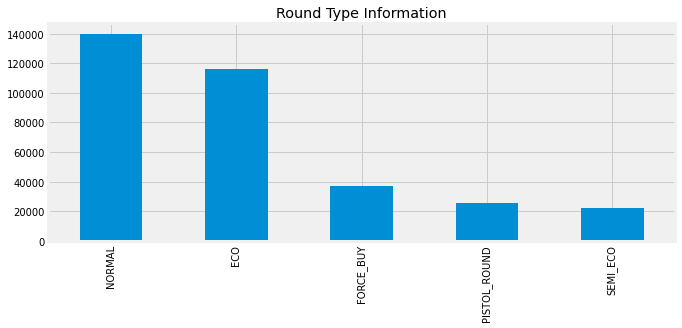

In [8]:
df_master_kills_demos['round_type'].value_counts().plot.bar(title="Round Type Information", **plt_kwargs)

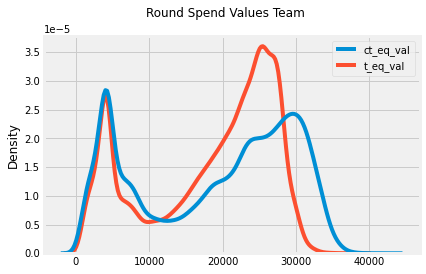

In [11]:
# Round Spend Analysis
distribution_plot_kde([df_master_kills_demos['ct_eq_val'], df_master_kills_demos['t_eq_val']], "Round Spend Values Team")


In [15]:
df_master_kills_demos = df_master_kills_demos[0:10000]

df_new_data = pd.DataFrame()
for i, row in df_master_kills_demos.iterrows():
  if row["winner_side"] == "CounterTerrorist":
    df_new_data.at[i, "winner"] = True
    df_new_data.at[i, "point_difference"] = row['ct_eq_val'] - row['t_eq_val']
  else:
    df_new_data.at[i, "winner"] = False
    df_new_data.at[i, "point_difference"] = -(row['ct_eq_val'] - row['t_eq_val'])

df_new_data


,winner,point_difference
0,False,-50.0
1,False,13100.0
2,False,11600.0
3,False,-1500.0
4,True,-15150.0
...,...,...
9995,True,25400.0
9996,False,-6950.0
9997,True,-100.0
9998,False,-9500.0


Text(0, 0.5, 'Probability Rounds Won')

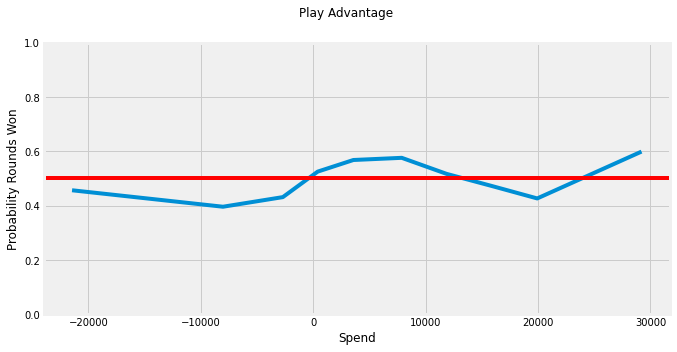

In [16]:
df_new_data = df_new_data.assign(pointdiff_groups=pd.qcut(df_new_data.point_difference, 10)).groupby("pointdiff_groups").apply(lambda df_new_data: df_new_data.winner.sum() / len(df_new_data.winner))

df_new_data.index = df_new_data.index.values.map(lambda val: val.left + (val.right - val.left) / 2).astype(int)

fig = plt.figure(figsize=(10, 5))
df_new_data.plot.line()
plt.suptitle("Play Advantage")
ax = plt.gca()
ax.axhline(0.5, color='red')
ax.set_ylim([0, 1])
ax.set_xlabel('Spend')
ax.set_ylabel("Probability Rounds Won")

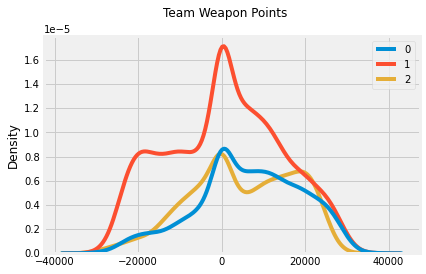

In [18]:
ct = df_master_kills_demos.query('winner_side == "CounterTerrorist"').pipe(lambda df_new_data: df_new_data.ct_eq_val - df_new_data.t_eq_val)
all_matches = df_master_kills_demos.pipe(lambda df_new_data: df_new_data.ct_eq_val - df_new_data.t_eq_val)
t = df_master_kills_demos.query('winner_side == "Terrorist"').pipe(lambda df_new_data: -(df_new_data.ct_eq_val - df_new_data.t_eq_val))

distribution_plot_kde([ct.tolist(), all_matches.tolist(), t.tolist()], "Team Weapon Points")


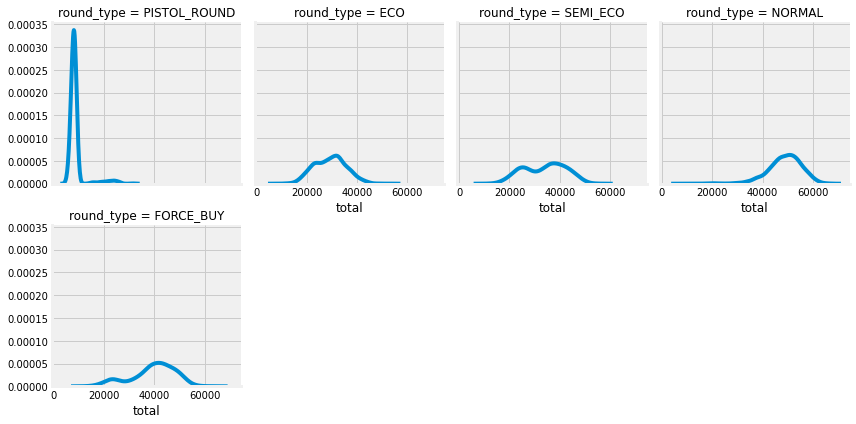

In [20]:
g = sns.FacetGrid(df_master_kills_demos.assign(
    total=df_master_kills_demos['ct_eq_val'] + df_master_kills_demos['t_eq_val']
), col="round_type", col_wrap=4)
g.map(sns.kdeplot, 'total')

In [21]:
df_kills = pd.read_csv("kill_data.csv")

df_kills.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
0,esea_match_13770997.dem,1,16058,30.74165,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
1,esea_match_13770997.dem,1,16210,31.93185,Team 2,Team 1,Terrorist,CounterTerrorist,Glock,Pistol,4,4,False
2,esea_match_13770997.dem,1,16510,34.28094,Team 2,Team 1,Terrorist,CounterTerrorist,Glock,Pistol,3,4,False
3,esea_match_13770997.dem,1,17104,38.93212,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,3,3,False
4,esea_match_13770997.dem,1,17338,40.76441,Team 2,Team 1,Terrorist,CounterTerrorist,Glock,Pistol,2,3,False


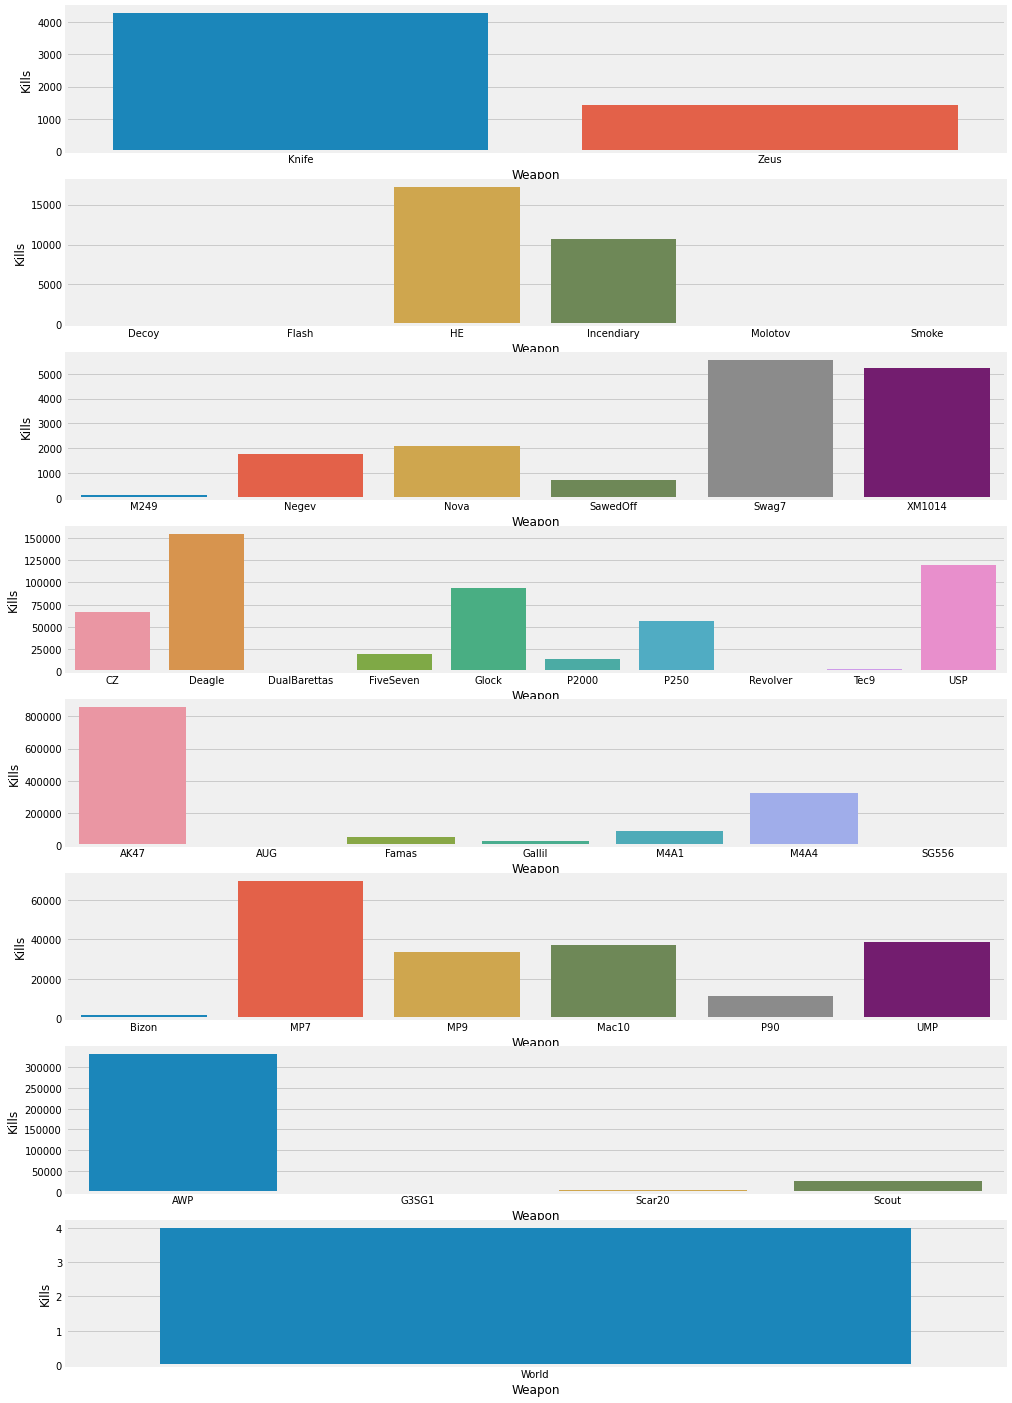

In [24]:
df_kills = pd.read_csv("kill_data.csv")

weapon_kills_data = df_kills.groupby(['wp_type','wp']).count().reset_index()[['wp_type','wp','file']]

weapon_kills_data = weapon_kills_data.rename(columns = {'wp_type':'Weapon_Type', 'wp':'Weapon', 'file':'Kills'})


fig, axs = plt.subplots(ncols=1, nrows=8, figsize = (15,25)) 
for axis_number in range(len(axs)): # loop through the subplots and plot the relavent data
    weaponType = weapon_kills_data['Weapon_Type'].unique()[axis_number]
    plot_to_plot = weapon_kills_data[weapon_kills_data['Weapon_Type']==weaponType]
    sns.barplot(x='Weapon', y='Kills', data=plot_to_plot, ax = axs[axis_number])

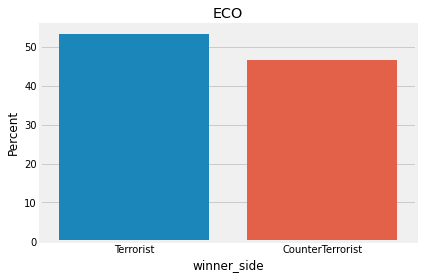

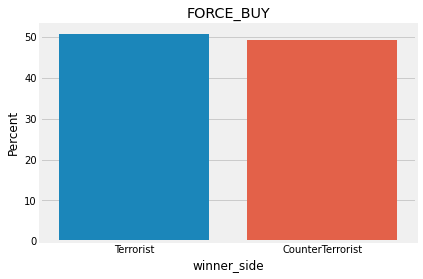

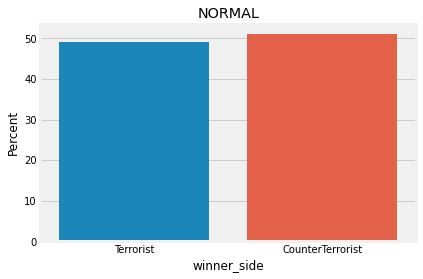

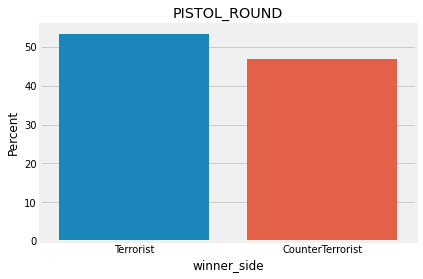

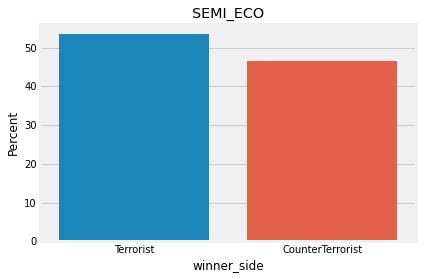

In [25]:
df_master_kills_demos = pd.read_csv("meta_data.csv")

# df_master_kills_demos = df_master_kills_demos[df_master_kills_demos["file"] == "esea_match_13770997.dem"]

df_group_by = df_master_kills_demos.groupby(df_master_kills_demos["round_type"])
n_count = len(df_master_kills_demos["round_type"].unique())

count = 0
# fig,ax = plt.subplots(n_count,1, figsize=(6,n_count*2), sharex=True)
for i, group in df_group_by:
  plt.figure(count)
  group["winner_side"] = group['winner_side'].apply(lambda x: 1 if x == "CounterTerrorist" else 0)
  ax = sns.barplot(x='winner_side', y='winner_side', data=group, estimator=lambda x: len(x) / len(group) * 100)
  ax.set(xticklabels=["Terrorist", "CounterTerrorist"])
  ax.set(ylabel="Percent")  
  ax.set_title(i)
  count+=1


